In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/My\ Drive/TESIS/autism-master/

Mounted at /content/gdrive/
/content/gdrive/My Drive/TESIS/autism-master


La idea es testear la significatividad de la diferencia entre el modelo de XGB con Anatomía + BASC-197 (pcorr) (cosine) para el diagrama de persistencia vs la matriz diagonalizada.

Idea general:
- Generar las matrices, guardarlas
- Generar los diagramas, vectorizarlos, guardarlos
- Tener las features anatómicas
- Tener el vector de labels

Fijando un n-FCV, (n=3?), fijando un número N de iteraciones, y con métricas ACC, PRE, REC, AUC.

## Setup

In [ ]:
%%capture
import os
import sys
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
!{sys.executable} -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master
!{sys.executable} -m pip install scikit-learn seaborn nilearn
from problem import get_cv
from download_data import fetch_fmri_time_series
from problem import get_train_data
!pip install ripser
from ripser import ripser
from persim import plot_diagrams
!pip install tensorflow_addons  
!pip install gudhi
import pickle as pkl
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from tensorflow import random_uniform_initializer as rui
import gudhi.representations as tda
import tensorflow as tf
import os.path
import itertools
import h5py
import tensorflow_addons  as tfa
import gudhi              as gd
from scipy.sparse           import csgraph
from scipy.io               import loadmat
from scipy.linalg           import eigh
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
# Reduccion dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
!pip install git+https://github.com/MathieuCarriere/perslay
!pip install git+https://github.com/MathieuCarriere/sklearn-tda
from perslay import PerslayModel
from scipy.stats import beta
!pip install nilearn
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
!pip install xgboost
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
import time
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

from nilearn.connectome import ConnectivityMeasure
from nilearn.connectome import vec_to_sym_matrix

from sklearn.pipeline import Pipeline
from perslay import PerslayModel
from ripser import ripser
import tensorflow_addons  as tfa
import gudhi.representations as tda
import tensorflow as tf
import gudhi              as gd
from tensorflow import random_uniform_initializer as rui
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
def ripser_diagram(paciente, hom_over_p=2, hom_dimension = 1, distm = True):
    diag = ripser(paciente, distance_matrix=distm, coeff = hom_over_p, maxdim=hom_dimension)['dgms']
    return(diag)


def gen_diags_dict(Dg):
  Len = len(Dg)
  diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}
  ep = 0.01
  for i in range(Len):
    if len(Dg[i][0]) == 0:
      diags_dict['Rips_dim_0'].append(np.array([[1,1+ep],[1.5,1.5+ep], [0.5,0.5+ep]]))
    else:
      diags_dict['Rips_dim_0'].append(np.array(np.append(Dg[i][0],[[1,1+ep],[1.5,1.5+ep], [0.5,0.5+ep]], axis=0)))
    if len(Dg[i][1]) == 0:
      diags_dict['Rips_dim_1'].append(np.array([[1,1+ep],[1.5,1.5+ep], [0.5,0.5+ep]]))
    else:
      diags_dict['Rips_dim_1'].append(np.array(np.append(Dg[i][1],[[1,1+ep],[1.5,1.5+ep], [0.5,0.5+ep]], axis=0)))
  return diags_dict

def diag_prepro(diags_dict, use_selector = True, use_prominent = True, thresh = 500, use_scaler = True, use_padding = True):
  
  # https://gudhi.inria.fr/python/3.1.0.rc1/representations.html
  # Whole pipeline
  tmp = Pipeline([
          ("Selector",      tda.DiagramSelector(use=use_selector, point_type="finite")),
          ("ProminentPts",  tda.ProminentPoints(use=use_prominent, num_pts=thresh)),
          ("Scaler",        tda.DiagramScaler(use=use_scaler, scalers=[([0,1], MinMaxScaler())])),
          ("Padding",       tda.Padding(use=use_padding)),
                  ])

  prm = {filt: {"ProminentPts__num_pts": min(thresh, max([len(dgm) for dgm in diags_dict[filt]]))} 
        for filt in diags_dict.keys() if max([len(dgm) for dgm in diags_dict[filt]]) > 0}

  # Apply the previous pipeline on the different filtrations.
  diags = []
  for dt in prm.keys():
      param = prm[dt]
      tmp.set_params(**param)
      diags.append(tmp.fit_transform(diags_dict[dt]))

  # For each filtration, concatenate all diagrams in a single array.
  D, npts = [], len(diags[0])
  for dt in range(len(prm.keys())):
      D.append(np.array(np.concatenate([diags[dt][i][np.newaxis,:] for i in range(npts)],axis=0),dtype=np.float32))
  
  return D

def load_architecture_params(weight, len_d, layer = "Image", perm_op = "mean"):
  perslay_parameters = []
  perslay_channel = {}

  perslay_channel["pweight_train"] = True
  perslay_channel["layer_train"]   = True
  perslay_channel["final_model"]   = tf.keras.Sequential([tf.keras.layers.Flatten()])

  if layer == "Landscape":
    perslay_channel["layer"]           = "Landscape"
    perslay_channel["lsample_num"]     = 100
    perslay_channel["lsample_init"]    = rui(0.0, 1.0)

  if layer == "Image":
    perslay_channel["layer"]           = "Image"
    perslay_channel["image_size"]      = (20, 20)
    perslay_channel["image_bnds"]      = ((-.001, 2.001), (-.001, 2.001))
    perslay_channel["lvariance_init"]  = 3.


  if weight == "gmix":
    perslay_channel["pweight"]       = "gmix"
    perslay_channel["pweight_num"]   = 3
    perslay_channel["pweight_init"]  = np.array(np.vstack([np.random.uniform(0.,1.,[2,3]),
                                                          5.*np.ones([2,3])]), dtype=np.float32)
  if weight == "power":
    perslay_channel["pweight"]       = "power"
    perslay_channel["pweight_init"]  = 1.
    perslay_channel["pweight_power"] = 1

  if weight == "grid":
    perslay_channel["pweight"]       = "grid"
    perslay_channel["pweight_size"]  = [20,20]
    perslay_channel["pweight_bnds"]  = ((-.001, 1.001), (-.001, 1.001))
    perslay_channel["pweight_init"]  = rui(1.0, 1.0)
  
  if weight == "None":
    perslay_channel["pweight"]       = None

  perslay_channel["perm_op"] = perm_op
  # mean, max, sum, topk

  if perm_op == "topk":
    perslay_channel["keep"]  = 10

  perslay_parameters = [perslay_channel for _ in range(len_d)]

  return perslay_parameters

def vector_representations(D, perslay_parameters):
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
      
      # Final rho network is a simple dense layer to the number of labels 
      rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(800,))])
      model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)

      # Optimizer is Adam with exponential decay of learning rate and moving average of variables
      lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.01, decay_steps=20, decay_rate=0.5)
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
      optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 

      # Loss is cross-entropy
      loss = tf.keras.losses.CategoricalCrossentropy()

      # Metric is accuracy
      metrics = [tf.keras.metrics.CategoricalAccuracy()]

  vectors = model.compute_representations(D).numpy()
  return vectors

def triag_array(array):
    return(array[np.triu_indices_from(array)])

def _load_fmri(fmri_filenames):
    """Load time-series extracted from the fMRI using a specific atlas."""
    return np.array([pd.read_csv(subject_filename,
                                 header=None).values
                     for subject_filename in fmri_filenames])


In [ ]:
class FeatureExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        # make a transformer which will load the time series and compute the
        # connectome matrix
        self.transformer_fmri = make_pipeline(
            FunctionTransformer(func=_load_fmri, validate=False),
            ConnectivityMeasure(kind='partial correlation', vectorize=True))

    def fit(self, X_df, y):
        fmri_filenames = X_df['fmri_basc197']
        self.transformer_fmri.fit(fmri_filenames, y)
        return self

    def transform(self, X_df):
        fmri_filenames = X_df['fmri_basc197']
        X_connectome = self.transformer_fmri.transform(fmri_filenames)
        X_rips = []
        Len = len(X_connectome)
        for i in range(Len):
            mat = vec_to_sym_matrix(X_connectome[i])
            dgm = ripser_diagram(mat)
            X_rips.append(dgm)
        X_rips = np.nan_to_num(X_rips)
                  
        # get the anatomical information
        X_anatomy = X_df[[col for col in X_df.columns
                          if col.startswith('anatomy')]]
        X_anatomy = X_anatomy.drop(columns='anatomy_select')
        scaler = StandardScaler()
        X_anatomy = scaler.fit_transform(X_anatomy)
        
        # get the ripser diagram
        diags_dict = gen_diags_dict(X_rips)
        F = np.array([[]]*Len)
        D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)
        lend = len(D)
        perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Image", perm_op = "sum")
        X_ripser = vector_representations(D, perslay_parameters)
        X_ripser = np.nan_to_num(X_ripser)

        # return
        return X_anatomy, X_connectome, X_ripser

In [ ]:
data_train.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,anatomy_lh_lateralorbitofrontal_area,anatomy_lh_lingual_area,anatomy_lh_medialorbitofrontal_area,anatomy_lh_middletemporal_area,anatomy_lh_parahippocampal_area,anatomy_lh_paracentral_area,anatomy_lh_parsopercularis_area,anatomy_lh_parsorbitalis_area,anatomy_lh_parstriangularis_area,anatomy_lh_pericalcarine_area,anatomy_lh_postcentral_area,anatomy_lh_posteriorcingulate_area,anatomy_lh_precentral_area,anatomy_lh_precuneus_area,anatomy_lh_rostralanteriorcingulate_area,anatomy_lh_rostralmiddlefrontal_area,anatomy_lh_superiorfrontal_area,anatomy_lh_superiorparietal_area,anatomy_lh_superiortemporal_area,anatomy_lh_supramarginal_area,anatomy_lh_frontalpole_area,anatomy_lh_temporalpole_area,anatomy_lh_transversetemporal_area,anatomy_lh_insula_area,anatomy_lh_WhiteSurfArea_area,anatomy_rh_bankssts_area,anatomy_rh_caudalanteriorcingulate_area,...,anatomy_Right-non-WM-hypointensities,anatomy_Optic-Chiasm,anatomy_CC_Posterior,anatomy_CC_Mid_Posterior,anatomy_CC_Central,anatomy_CC_Mid_Anterior,anatomy_CC_Anterior,anatomy_BrainSegVol,anatomy_BrainSegVolNotVentSurf,anatomy_lhCortexVol,anatomy_rhCortexVol,anatomy_CortexVol,anatomy_lhCerebralWhiteMatterVol,anatomy_rhCerebralWhiteMatterVol,anatomy_CerebralWhiteMatterVol,anatomy_SubCortGrayVol,anatomy_TotalGrayVol,anatomy_SupraTentorialVol,anatomy_SupraTentorialVolNotVent,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol-to-eTIV,anatomy_MaskVol-to-eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_BrainSegVolNotVent,anatomy_select,fmri_basc064,fmri_basc122,fmri_basc197,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_motions,fmri_msdl,fmri_power_2011,fmri_select,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,F,9.301370,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,3305.0,897.0,4406.0,2840.0,2571.0,1693.0,2953.0,669.0,1251.0,1508.0,615.0,1380.0,1267.0,3956.0,926.0,4490.0,4097.0,685.0,5423.0,7040.0,6391.0,3471.0,4013.0,225.0,478.0,415.0,2020.0,81059.6,850.0,534.0,...,0.0,263.7,757.6,462.6,446.1,400.8,819.5,1073332.0,1.059829e+06,262826.404548,261285.128186,524111.532734,183110.242509,181879.257294,364989.499803,53149.0,673569.532734,9.548540e+05,9.433810e+05,941139.0,1375171.0,0.840976,1.077472,30.0,31.0,61.0,1.276294e+06,1.276294e+06,1058903.0,1,./data/fmri/basc064/1932355398536124106/run_1/...,./data/fmri/basc122/1932355398536124106/run_1/...,./data/fmri/basc197/1932355398536124106/run_1/...,./data/fmri/craddock_scorr_mean/19323553985361...,./data/fmri/harvard_oxford_cort_prob_2mm/19323...,./data/fmri/motions/1932355398536124106/run_1/...,./data/fmri/msdl/1932355398536124106/run_1/193...,./data/fmri/power_2011/1932355398536124106/run...,1,2.5
5174041730092253771,19,M,29.000000,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,3555.0,1155.0,5611.0,2867.0,3412.0,1963.0,4112.0,670.0,1545.0,2342.0,878.0,1961.0,1587.0,4288.0,1330.0,5073.0,4378.0,999.0,6376.0,7851.0,5794.0,4484.0,4689.0,249.0,490.0,448.0,2708.0,96260.5,925.0,911.0,...,0.0,163.0,902.0,603.0,527.4,507.9,1044.4,1349407.0,1.329346e+06,284683.699493,287393.006096,572076.705589,268366.061339,271307.630193,539673.691532,70140.0,759505.705589,1.199671e+06,1.183773e+06,1181796.0,1807924.0,0.771229,1.033285,45.0,54.0,99.0,1.749685e+06,1.749685e+06,1329340.0,1,./data/fmri/basc064/5174041730092253771/run_1/...,./data/fmri/basc122/5174041730092253771/run_1/...,./data/fmri/basc197/5174041730092253771/run_1/...,./data/fmri/craddock_scorr_mean/51740417300922...,./data/fmri/harvard_oxford_cort_prob_2mm/5

In [ ]:
data_sub = data_train.iloc[0:30]
labels_sub=labels_train[0:30]

In [ ]:
data_sub.shape, labels_sub.shape


((30, 221), (30,))

In [ ]:
data_sub.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,anatomy_lh_lateralorbitofrontal_area,anatomy_lh_lingual_area,anatomy_lh_medialorbitofrontal_area,anatomy_lh_middletemporal_area,anatomy_lh_parahippocampal_area,anatomy_lh_paracentral_area,anatomy_lh_parsopercularis_area,anatomy_lh_parsorbitalis_area,anatomy_lh_parstriangularis_area,anatomy_lh_pericalcarine_area,anatomy_lh_postcentral_area,anatomy_lh_posteriorcingulate_area,anatomy_lh_precentral_area,anatomy_lh_precuneus_area,anatomy_lh_rostralanteriorcingulate_area,anatomy_lh_rostralmiddlefrontal_area,anatomy_lh_superiorfrontal_area,anatomy_lh_superiorparietal_area,anatomy_lh_superiortemporal_area,anatomy_lh_supramarginal_area,anatomy_lh_frontalpole_area,anatomy_lh_temporalpole_area,anatomy_lh_transversetemporal_area,anatomy_lh_insula_area,anatomy_lh_WhiteSurfArea_area,anatomy_rh_bankssts_area,anatomy_rh_caudalanteriorcingulate_area,...,anatomy_Right-non-WM-hypointensities,anatomy_Optic-Chiasm,anatomy_CC_Posterior,anatomy_CC_Mid_Posterior,anatomy_CC_Central,anatomy_CC_Mid_Anterior,anatomy_CC_Anterior,anatomy_BrainSegVol,anatomy_BrainSegVolNotVentSurf,anatomy_lhCortexVol,anatomy_rhCortexVol,anatomy_CortexVol,anatomy_lhCerebralWhiteMatterVol,anatomy_rhCerebralWhiteMatterVol,anatomy_CerebralWhiteMatterVol,anatomy_SubCortGrayVol,anatomy_TotalGrayVol,anatomy_SupraTentorialVol,anatomy_SupraTentorialVolNotVent,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol-to-eTIV,anatomy_MaskVol-to-eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_BrainSegVolNotVent,anatomy_select,fmri_basc064,fmri_basc122,fmri_basc197,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_motions,fmri_msdl,fmri_power_2011,fmri_select,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,F,9.301370,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,3305.0,897.0,4406.0,2840.0,2571.0,1693.0,2953.0,669.0,1251.0,1508.0,615.0,1380.0,1267.0,3956.0,926.0,4490.0,4097.0,685.0,5423.0,7040.0,6391.0,3471.0,4013.0,225.0,478.0,415.0,2020.0,81059.6,850.0,534.0,...,0.0,263.7,757.6,462.6,446.1,400.8,819.5,1073332.0,1.059829e+06,262826.404548,261285.128186,524111.532734,183110.242509,181879.257294,364989.499803,53149.0,673569.532734,9.548540e+05,9.433810e+05,941139.0,1375171.0,0.840976,1.077472,30.0,31.0,61.0,1.276294e+06,1.276294e+06,1058903.0,1,./data/fmri/basc064/1932355398536124106/run_1/...,./data/fmri/basc122/1932355398536124106/run_1/...,./data/fmri/basc197/1932355398536124106/run_1/...,./data/fmri/craddock_scorr_mean/19323553985361...,./data/fmri/harvard_oxford_cort_prob_2mm/19323...,./data/fmri/motions/1932355398536124106/run_1/...,./data/fmri/msdl/1932355398536124106/run_1/193...,./data/fmri/power_2011/1932355398536124106/run...,1,2.5
5174041730092253771,19,M,29.000000,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,3555.0,1155.0,5611.0,2867.0,3412.0,1963.0,4112.0,670.0,1545.0,2342.0,878.0,1961.0,1587.0,4288.0,1330.0,5073.0,4378.0,999.0,6376.0,7851.0,5794.0,4484.0,4689.0,249.0,490.0,448.0,2708.0,96260.5,925.0,911.0,...,0.0,163.0,902.0,603.0,527.4,507.9,1044.4,1349407.0,1.329346e+06,284683.699493,287393.006096,572076.705589,268366.061339,271307.630193,539673.691532,70140.0,759505.705589,1.199671e+06,1.183773e+06,1181796.0,1807924.0,0.771229,1.033285,45.0,54.0,99.0,1.749685e+06,1.749685e+06,1329340.0,1,./data/fmri/basc064/5174041730092253771/run_1/...,./data/fmri/basc122/5174041730092253771/run_1/...,./data/fmri/basc197/5174041730092253771/run_1/...,./data/fmri/craddock_scorr_mean/51740417300922...,./data/fmri/harvard_oxford_cort_prob_2mm/5

## Data

In [ ]:
# Generar 3 arrays de np
# El primero que tenga los datos anatómicos
# El segundo las matrices diagonalizadas
# El tercero los diagramas diagonalizados
# Guardarlos para que sean de fácil acceso

In [ ]:
data_train, labels_train = get_train_data()

In [ ]:
feat_ext = FeatureExtractor()
feat_ext.fit(data_train, labels_train)

FeatureExtractor()

In [ ]:
X_anatomy, X_connectome, X_ripser = feat_ext.transform(data_train)

In [ ]:
X_anatomy.shape, X_connectome.shape, X_ripser.shape

((1127, 207), (1127, 19503), (1127, 800))

In [ ]:
import pickle

In [ ]:
with open('results/X_anatomy.pkl', 'wb') as handle:
    pickle.dump(X_anatomy, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('results/X_connectome.pkl', 'wb') as handle:
    pickle.dump(X_connectome, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('results/X_ripser.pkl', 'wb') as handle:
    pickle.dump(X_ripser, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
        # get the anatomical information
        X_anatomy = data_train[[col for col in data_train.columns
                          if col.startswith('anatomy')]]
        X_anatomy = X_anatomy.drop(columns='anatomy_select')
        scaler = StandardScaler()
        X_anatomy = scaler.fit_transform(X_anatomy)

In [ ]:
with open('results/X_ripser.pkl', 'rb') as f:
    X_ripser = pickle.load(f)

#with open('results/X_anatomy.pkl', 'rb') as g:
#    X_anatomy = pickle.load(g)

with open('results/X_connectome.pkl', 'rb') as h:
    X_connectome = pickle.load(h)

In [ ]:
X_anatomy.shape, X_connectome.shape, X_ripser.shape

((1127, 207), (1127, 19503), (1127, 800))

## Modelos

In [ ]:
#For i in range(N):
#  shuffle labels
#  for fold in num-folds:
#    train model M (matrices)
#    train model D (diagramas)
#    predict M, D
#    return metrics(D)-metrics(M)

# comparar con el modelo corrido sobre las labels reales.

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
class Classifier(BaseEstimator):
    def __init__(self, est = 'RF'):
      #XGBClassifier()
      #RandomForestClassifier(n_estimators = 300)
      self.clf_ripser = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 300))
    def fit(self, X, y):
        self.clf_ripser.fit(X, y)
        return self
    def predict(self, X):
        return self.clf_ripser.predict(X)
    def predict_proba(self, X):
        return self.clf_ripser.predict_proba(X)

def get_cv(X, y):
    cv = StratifiedShuffleSplit(n_splits=5, test_size=None, random_state=42)
    return cv.split(X, y)

def evaluation(X, y):
    pipe = make_pipeline(Classifier(est='RF'))
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy', 'precision', 'recall'], cv=cv,
                             verbose=3, return_train_score=True,
                             n_jobs=-1)
    
    return results

In [ ]:
X1 = np.concatenate((X_anatomy, X_ripser), axis=1)
X1.shape

(30, 1007)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
results=evaluation(X1,labels_sub)
print("ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['test_roc_auc']), np.std(results['test_roc_auc'])))
print("accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']), np.std(results['test_accuracy'])))
print("precision: {:.3f} +- {:.3f}".format(np.mean(results['test_precision']), np.std(results['test_precision'])))
print("recall: {:.3f} +- {:.3f}".format(np.mean(results['test_recall']), np.std(results['test_recall'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROC-AUC: 0.000 +- 0.000
accuracy: 0.556 +- 0.157
precision: 0.000 +- 0.000
recall: 0.000 +- 0.000


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
import pickle
import random
import matplotlib.pyplot as plt


In [ ]:
with open('results_conn_list.pkl', 'rb') as f:
    results_conn_list = pickle.load(f)

with open('results_rips_list.pkl', 'rb') as f:
    results_rips_list = pickle.load(f)

In [ ]:
X_anatomy_connectome = np.concatenate((X_anatomy, X_connectome), axis=1)
X_anatomy_ripser = np.concatenate((X_anatomy, X_ripser), axis=1)

results_conn_list = []
results_rips_list = []

results_only_anatomy = []
results_anatomy_rips = []

label_shuffle = list(labels_train)

reps = 500  

In [ ]:
#with open('results_conn_list.pkl', 'wb') as handle:
#    pickle.dump(results_conn_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('results_rips_list.pkl', 'wb') as handle:
#    pickle.dump(results_rips_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('results_only_anatomy.pkl', 'wb') as handle:
    pickle.dump(results_only_anatomy, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results_anatomy_rips.pkl', 'wb') as handle:
    pickle.dump(results_anatomy_rips, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('results_only_anatomy.pkl', 'rb') as f:
    results_only_anatomy = pickle.load(f)

with open('results_anatomy_rips.pkl', 'rb') as f:
    results_anatomy_rips = pickle.load(f)

In [ ]:
for i in range(152,reps):
  label_shuffle = random.sample(label_shuffle, len(label_shuffle))
  results_conn = evaluation(X_anatomy,label_shuffle)
  results_only_anatomy.append({'type': 'only_anatomy', 
                            'mean_roc': np.mean(results_conn['test_roc_auc']),
                            'mean_acc': np.mean(results_conn['test_accuracy']),
                            'mean_pre': np.mean(results_conn['test_precision']), 
                            'mean_rec': np.mean(results_conn['test_recall']), 
                            'sd_roc': np.std(results_conn['test_roc_auc']),
                            'sd_acc': np.std(results_conn['test_accuracy']), 
                            'sd_pre': np.std(results_conn['test_precision']), 
                            'sd_rec': np.std(results_conn['test_recall'])}
                          )

  results_rips = evaluation(X_anatomy_ripser,label_shuffle)
  results_anatomy_rips.append({'type': 'anatomy_rips', 
                            'mean_roc': np.mean(results_rips['test_roc_auc']),
                            'mean_acc': np.mean(results_rips['test_accuracy']),
                            'mean_pre': np.mean(results_rips['test_precision']), 
                            'mean_rec': np.mean(results_rips['test_recall']), 
                            'sd_roc': np.std(results_rips['test_roc_auc']),
                            'sd_acc': np.std(results_rips['test_accuracy']), 
                            'sd_pre': np.std(results_rips['test_precision']), 
                            'sd_rec': np.std(results_rips['test_recall'])}
                          )
  print(i)
  if i%10==0:
    with open('results_only_anatomy.pkl', 'wb') as handle:
      pickle.dump(results_only_anatomy, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results_anatomy_rips.pkl', 'wb') as handle:
      pickle.dump(results_anatomy_rips, handle, protocol=pickle.HIGHEST_PROTOCOL)




In [ ]:
#230 hice con rips+anatomy vs anatomy

In [ ]:
means_conn = [i['mean_acc'] for i in results_only_anatomy]
means_rips = [i['mean_acc'] for i in results_anatomy_rips]

[]

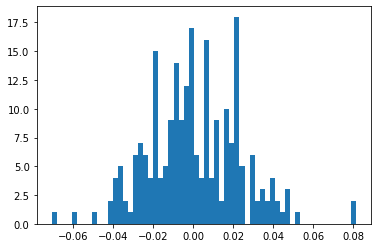

In [ ]:
means_diff = np.array(means_conn)-np.array(means_rips)
plt.hist(means_diff, bins=60)
plt.plot()

0.5084528532194079

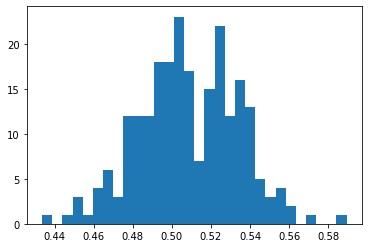

In [ ]:
plt.hist(means_conn, bins=30)
plt.plot()
np.mean(means_conn)

0.507857796765334

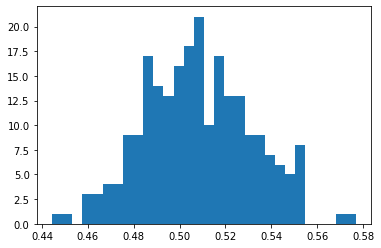

In [ ]:
plt.hist(means_rips, bins=30)
plt.plot()
np.mean(means_rips)

In [ ]:
ranges = np.arange(1,len(means_conn)+1)
cummean_conn = np.cumsum(means_conn)/ranges
cummean_rips = np.cumsum(means_rips)/ranges

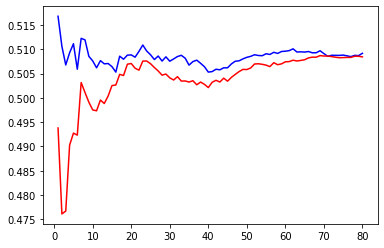

In [ ]:
plt.plot(ranges, cummean_conn, color = 'blue')
plt.plot(ranges, cummean_rips, color = 'red')

# Referencia

In [ ]:
with open('results/X_anatomy.pkl', 'rb') as f:
    X_anatomy = pickle.load(f)

with open('results/X_connectome.pkl', 'rb') as f:
    X_connectome = pickle.load(f)

with open('results/X_ripser.pkl', 'rb') as f:
    X_ripser = pickle.load(f)

In [ ]:
X_anatomy_connectome = np.concatenate((X_anatomy, X_connectome), axis=1)
X_anatomy_ripser = np.concatenate((X_anatomy, X_ripser), axis=1)

In [ ]:
results_anatomy_anatomy_real = []
results_anatomy_rips_real = []
results_conn = evaluation(X_anatomy,labels_train)
results_anatomy_anatomy_real.append({'type': 'anatomy_real', 
                          'mean_roc': np.mean(results_conn['test_roc_auc']),
                          'mean_acc': np.mean(results_conn['test_accuracy']),
                          'mean_pre': np.mean(results_conn['test_precision']), 
                          'mean_rec': np.mean(results_conn['test_recall']), 
                          'sd_roc': np.std(results_conn['test_roc_auc']),
                          'sd_acc': np.std(results_conn['test_accuracy']), 
                          'sd_pre': np.std(results_conn['test_precision']), 
                          'sd_rec': np.std(results_conn['test_recall'])}
                        )

results_rips = evaluation(X_anatomy_ripser,labels_train)
results_anatomy_rips_real.append({'type': 'ripser_anatomy_real', 
                          'mean_roc': np.mean(results_rips['test_roc_auc']),
                          'mean_acc': np.mean(results_rips['test_accuracy']),
                          'mean_pre': np.mean(results_rips['test_precision']), 
                          'mean_rec': np.mean(results_rips['test_recall']), 
                          'sd_roc': np.std(results_rips['test_roc_auc']),
                          'sd_acc': np.std(results_rips['test_accuracy']), 
                          'sd_pre': np.std(results_rips['test_precision']), 
                          'sd_rec': np.std(results_rips['test_recall'])}
                          )


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


In [ ]:
with open('results_anatomy_anatomy_real.pkl', 'wb') as handle:
    pickle.dump(results_anatomy_anatomy_real, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results_anatomy_rips_real.pkl', 'wb') as handle:
    pickle.dump(results_anatomy_rips_real, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('results_anatomy_anatomy_real.pkl', 'rb') as f:
    results_anatomy_anatomy_real = pickle.load(f)

with open('results_anatomy_rips_real.pkl', 'rb') as f:
    results_anatomy_rips_real = pickle.load(f)

In [ ]:
means_conn_real = [i['mean_acc'] for i in results_anatomy_anatomy_real]
means_rips_real = [i['mean_acc'] for i in results_anatomy_rips_real]
mean_diff_real = means_conn_real[0]-means_rips_real[0]

pval = (means_diff<mean_diff_real).sum()/len(means_diff)
pval

0.14224137931034483

In [ ]:
print((means_conn_real, means_rips_real, mean_diff_real))

([0.5823008849557522], [0.6053097345132743], -0.023008849557522137)


[]

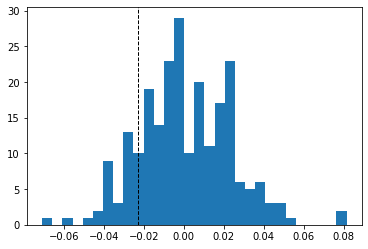

In [ ]:
plt.hist(means_diff, bins=30)
plt.axvline(mean_diff_real, color='k', linestyle='dashed', linewidth=1)
plt.plot()

In [ ]:
results_rips = evaluation(X_anatomy,labels_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


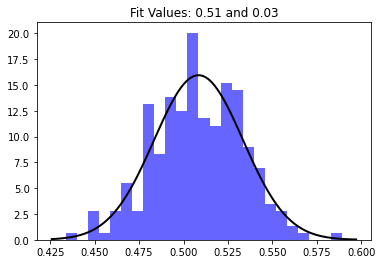

In [ ]:
from scipy.stats import norm

mu, std = np.mean(means_conn), np.std(means_conn)
  
# Plot the histogram.
plt.hist(means_conn, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

In [ ]:
np.mean(means_rips), np.std(means_rips)

(0.5085952598921777, 0.030849450499184517)

# Gráficos y p-valores totales

In [ ]:
from scipy.stats import norm

In [ ]:
random_1 = results_only_anatomy
random_2 = results_anatomy_rips
real_1 = results_anatomy_anatomy_real
real_2 = results_anatomy_rips_real
nombre_1 = 'solo anatomía'
nombre_2 = 'anatomía y diagramas'

In [ ]:
keys = ['mean_roc','mean_acc','mean_pre','mean_rec','sd_roc','sd_acc','sd_pre','sd_rec']
differences = []
reals = []
for key in keys:
  assert len(random_1)==len(random_2)
  diff = [random_1[i][key] - random_2[i][key] for i in range(len(random_1))]
  differences.append(diff)
  rel = [real_1[i][key] - real_2[i][key] for i in range(len(real_1))]
  reals.append(rel)

In [ ]:
pvals = []
i=0
for key in keys:
  pos = sum([np.abs(case)>np.abs(reals[i][0]) for case in differences[i]])
  pvals.append(round(pos/len(differences[i]), 5))
  i+=1

In [ ]:
i=0
sum([np.abs(case)>np.abs(reals[i][0]) for case in differences[i]])


143

0.34009571555213414

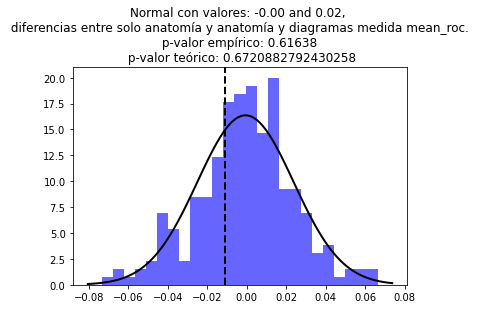

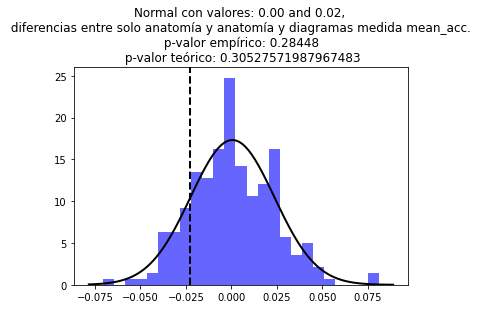

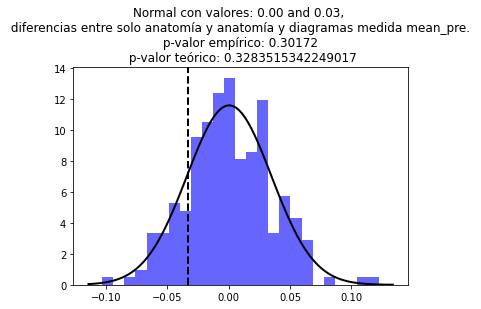

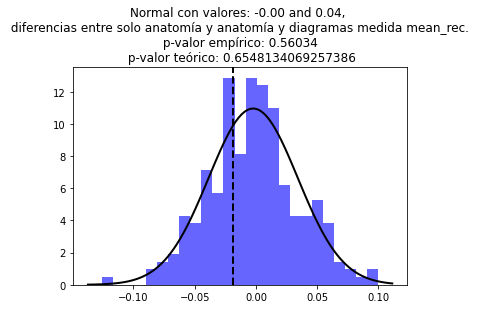

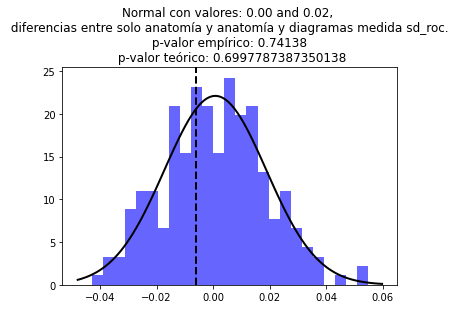

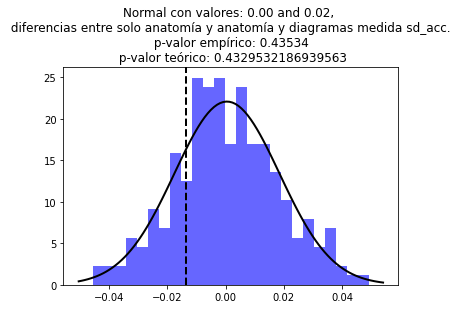

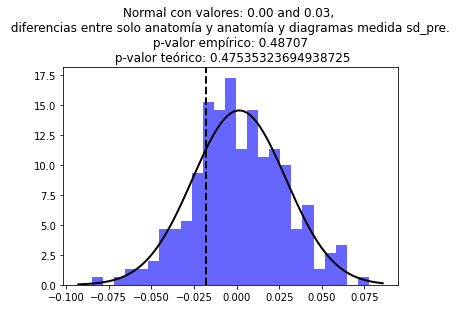

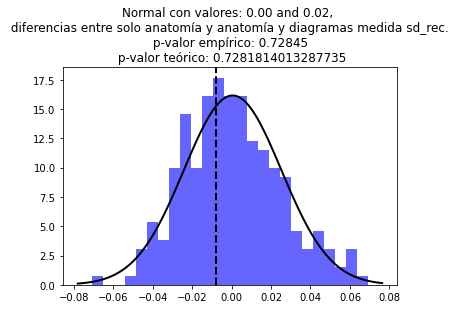

In [ ]:
i=0
for key in keys:
  mu, std = np.mean(differences[i]), np.std(differences[i])
  plt.hist(differences[i], bins=25, density=True, alpha=0.6, color='b')
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.plot(x, p, 'k', linewidth=2)
  plt.axvline(reals[i], color='k', linestyle='dashed', linewidth=2)
  pval_teorico = 2*norm.cdf(-np.abs(reals[i][0]),loc = mu, scale = std)
  title = "Normal con valores: {:.2f} and {:.2f}, \n diferencias entre {} y {} medida {}. \n p-valor empírico: {} \n p-valor teórico: {}".format(mu, std, nombre_1, nombre_2, key, pvals[i], pval_teorico)
  plt.title(title)
  plt.show()  
  i+=1